In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import copy

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

<span style="color: orange; font-size: 30px;">STEP 1: Dataset Loading </span>


First I load the dataset. This dataset contains the OHLCV data of the BTC market since 2014-09-17 to 2023-07-13. I also convert the Date column to datetime type and sort the dataset by that column.

Features: OLHCV stands for Open, Low, High, Close and Volume.

Open and Close refer to the the price of one share of that stock when the market started and stopped working on that day.

Low and High are the minimum and maximum price of that they as well.

Volume refers to the total number of shares traded for that stock over a specific period of time which is a day in our data.

In [2]:
df = pd.read_csv("BTC-USD.csv")
print(df.head())

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

print(df)

   Unnamed: 0        Date        Open        High         Low       Close  \
0           0  2014-09-17  465.864014  468.174011  452.421997  457.334015   
1           1  2014-09-18  456.859985  456.859985  413.104004  424.440002   
2           2  2014-09-19  424.102997  427.834991  384.532013  394.795990   
3           3  2014-09-20  394.673004  423.295990  389.882996  408.903992   
4           4  2014-09-21  408.084991  412.425995  393.181000  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  
      Unnamed: 0       Date          Open          High           Low  \
0              0 2014-09-17    465.864014    468.174011    452.421997   
1              1 2014-09-18    456.859985    456.859985    413.104004   
2              2 2014-09-19    424.102997    427.834991    384.532013   
3              3 2014-09-20    394.673004    423.295990    389.882996   
4              4 2014-09-21    408.084991    412.425995    393.181000   
...          ..

<span style="color: orange; font-size: 30px;">STEP 2: Exploratory Data Analysis </span>

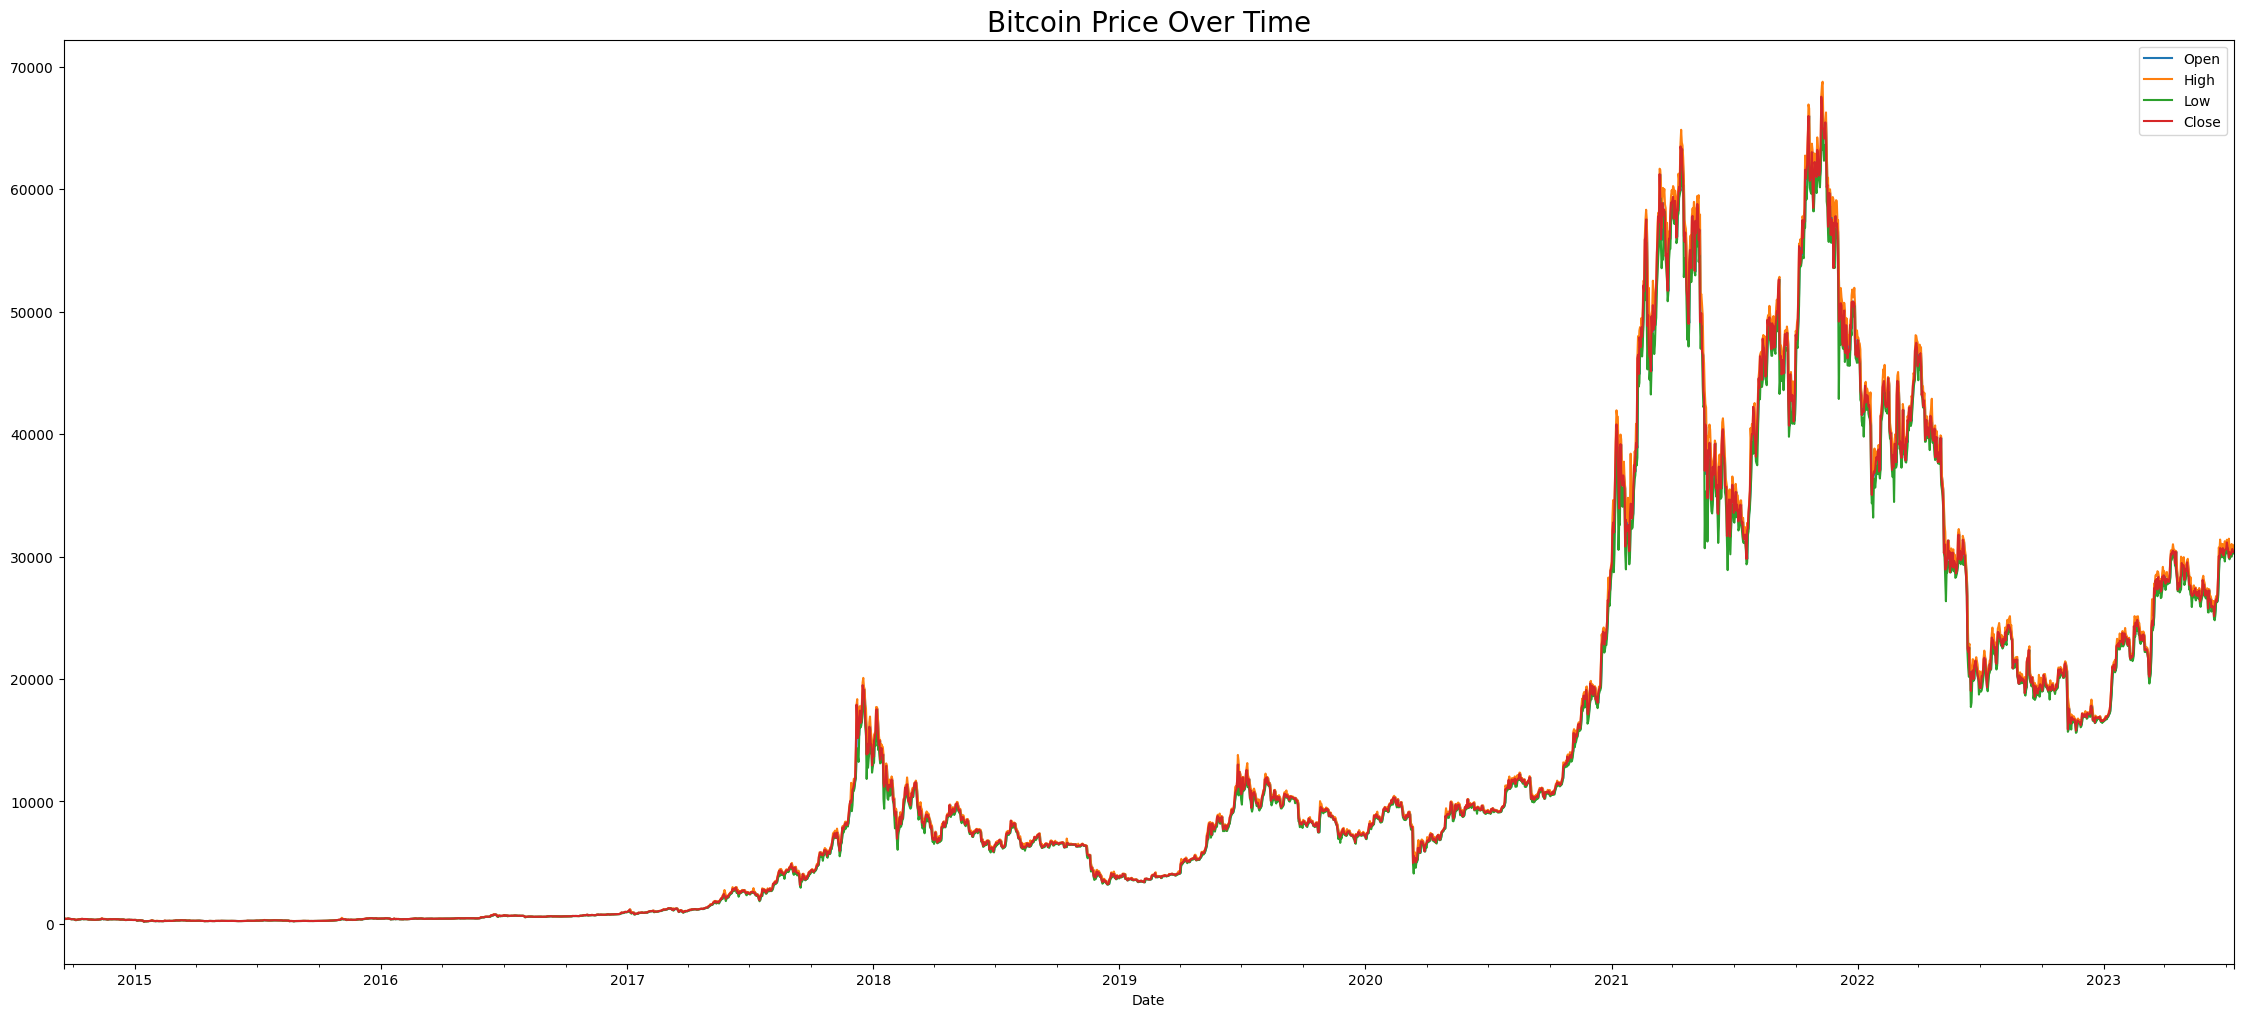

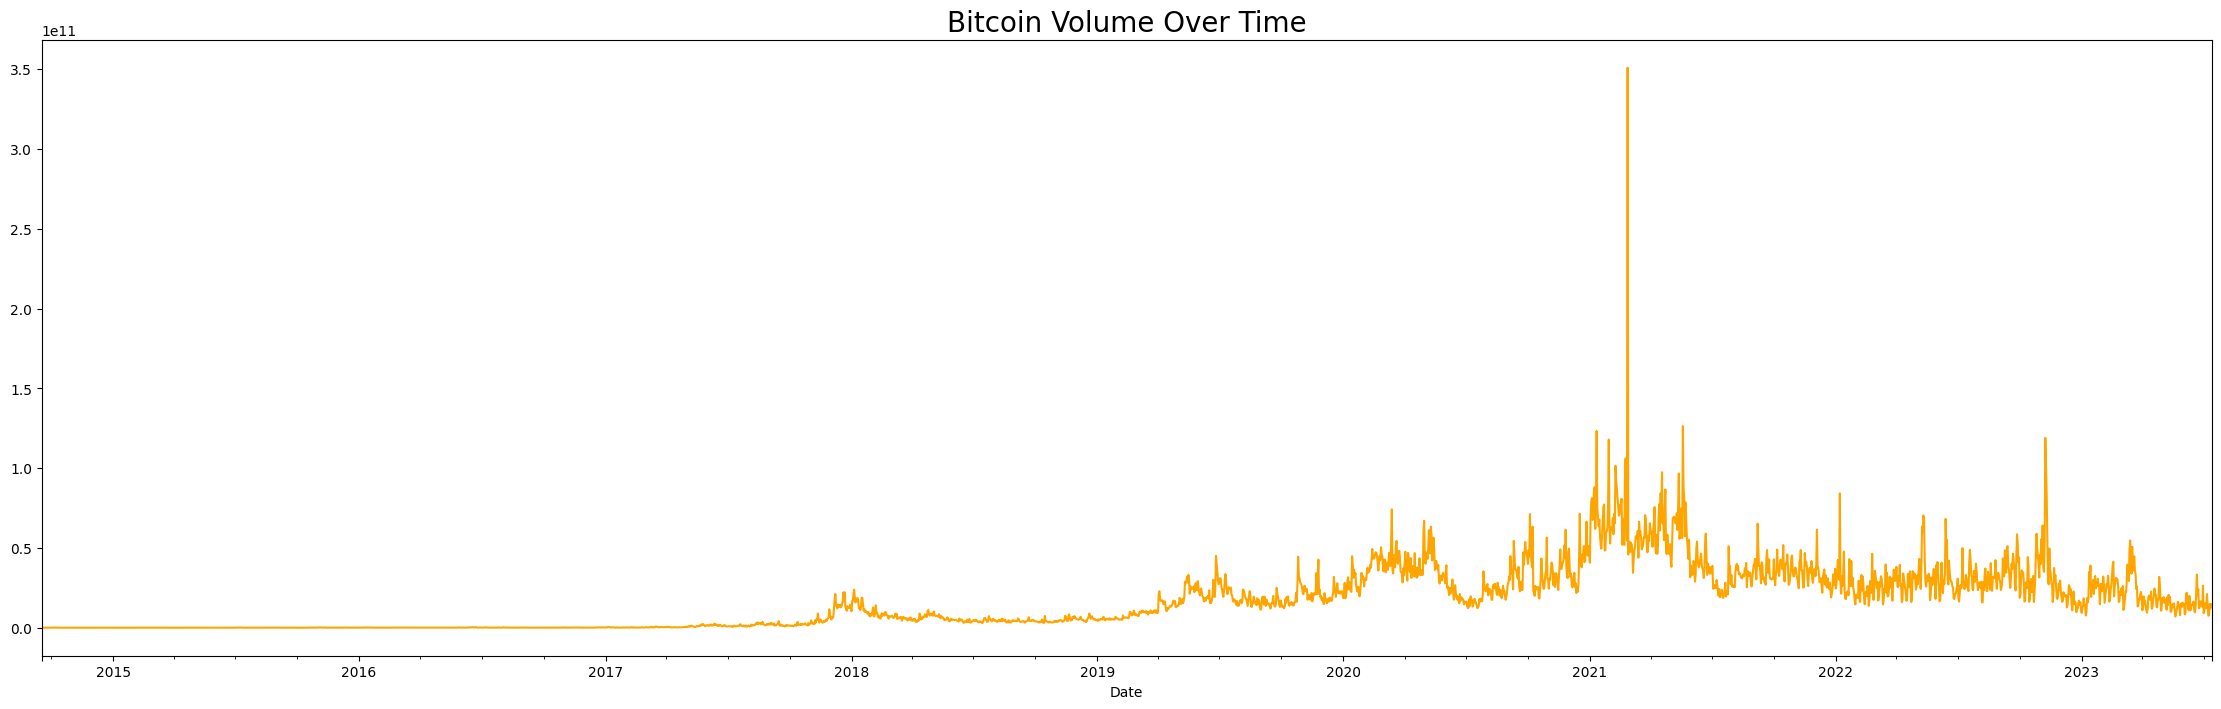

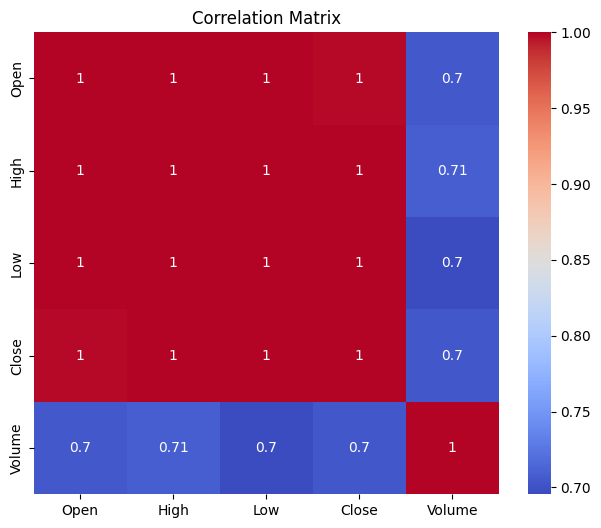

,Unnamed: 0,Date,Open,High,Low,Close,Volume
count,3222.00000,3222,3222.000000,3222.000000,3222.000000,3222.000000,3.222000e+03
mean,1610.50000,2019-02-13 11:59:59.999999744,13633.555524,13966.498897,13269.790975,13641.491658,1.657062e+10
min,0.00000,2014-09-17 00:00:00,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,805.25000,2016-11-30 06:00:00,757.838730,772.024277,745.732499,759.970260,1.300485e+08
50%,1610.50000,2019-02-13 12:00:00,7664.044434,7867.845215,7499.634766,7679.053711,1.017502e+10
75%,2415.75000,2021-04-28 18:00:00,20210.792481,20660.277832,19811.524414,20238.632813,2.746342e+10
max,3221.00000,2023-07-13 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11
std,930.25561,NaN,16016.593310,16417.423832,15559.562019,16014.439000,1.950701e+10


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

features_list = ["Open", "High", "Low", "Close"]
df.set_index("Date")[features_list].plot(figsize=(28, 12))
plt.title("Bitcoin Price Over Time", fontsize=20)
plt.show()

df.set_index("Date")["Volume"].plot(figsize=(28, 8), color='orange')
plt.title("Bitcoin Volume Over Time", fontsize=20)
plt.show()

correlation = df[["Open", "High", "Low", "Close", "Volume"]].corr()
plt.figure(figsize=(7.5, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

df.describe()

Analyze: The chart of Open, High, Low and Close features are almost the same. It shows the intense correlation between the price of shares in the current and next days. We can see this infrence in the third plot too. The correlation matrix shows 100% correlation between these four featurs!

Also there is a high correlation between Volume and other features. By the Volume time graph we can aquire that the peak of buying BTC shares was in the first half of 2021. At that time there might've been a huge demand for Bitcoin.

<span style="color: orange; font-size: 30px;">STEP 3: Data Processing</span>

<span style="color: blue; font-size: 20px;">Missing Data</span>

We have no missing data.

In [4]:
print("Number Of Missing Data:", df.isna().sum())
df = df.dropna()
df_processed = df.copy()

Number Of Missing Data: Unnamed: 0    0
Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64


<span style="color: blue; font-size: 20px;">Feature Engineering</span>

<span style="color: green; font-size: 18px;">Moving Average</span>

Because the recent data are more important to predict the next data, I add the weighted moving average feature which gives more importance to the recent prices exponentially. The decay factor has to be lower for more volatile markets and higher for more stable ones.

In [5]:
decay_factor = 0.75
lookback = 10

weights = [decay_factor**i for i in range(lookback)][::-1]

df_processed['weighted_ma'] = df_processed['Close'].rolling(lookback).apply(
    lambda x: np.dot(x, weights)/sum(weights)
)

<span style="color: green; font-size: 18px;">Liquidity Ratio</span>

In [6]:
window = 10
df_processed['volatility'] = df_processed['Close'].pct_change().rolling(window).std()
df_processed['liquidity_ratio'] = df_processed['Volume'] / df_processed['volatility']

In [7]:
print(df_processed['volatility'])
print(df_processed['liquidity_ratio'])
print(df_processed['weighted_ma'])

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
3217    0.011338
3218    0.011680
3219    0.011833
3220    0.012068
3221    0.010268
Name: volatility, Length: 3222, dtype: float64
0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
3217    6.970782e+11
3218    1.269562e+12
3219    1.026985e+12
3220    1.226855e+12
3221    1.411488e+12
Name: liquidity_ratio, Length: 3222, dtype: float64
0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
3217    30337.961430
3218    30356.152147
3219    30422.812482
3220    30411.602813
3221    30393.017043
Name: weighted_ma, Length: 3222, dtype: float64


<span style="color: blue; font-size: 20px;">Target Features</span>

<span style="color: green; font-size: 18px;">Future Return Over Holding Period</span>

This target feature tells us how many percent the Close price will change in the next n_periods days. It's a very effective and determining target feature for trading.

In [8]:
n_periods = 5

df_processed['future_return'] = df_processed['Close'].pct_change(n_periods).shift(-n_periods) * 100
print(df_processed['future_return'])

0      -12.066019
1        2.674343
2        7.195868
3        0.652968
4        1.405135
          ...    
3217          NaN
3218          NaN
3219          NaN
3220          NaN
3221          NaN
Name: future_return, Length: 3222, dtype: float64


<span style="color: green; font-size: 18px;">Volatility-Adjusted Return</span>

In the world of investment and trading, low risk is valued. So we bring the volatility in to consider how much the price will swing in the next 5 days. The less the better! We don't want to get psycho while trading.

In [9]:
epsilon = 1e-3
daily_returns = df_processed['Close'].pct_change()
df_processed['future_volatility'] = (daily_returns.rolling(n_periods).std().shift(-n_periods)).apply(lambda x: max(x, epsilon))

df_processed['adjusted_future_return'] = df_processed['future_return'] / df_processed['future_volatility'] / 100
print(df_processed['adjusted_future_return'])

0      -2.541952
1       0.458498
2       1.544306
3       0.135858
4       0.298038
          ...   
3217         NaN
3218         NaN
3219         NaN
3220         NaN
3221         NaN
Name: adjusted_future_return, Length: 3222, dtype: float64


<span style="color: green; font-size: 18px;">Next Day Close</span>

In [10]:
df_processed["next_day_close"] = df_processed["Close"].shift(-1)

<span style="color: blue; font-size: 20px;">Splitting and Scaling The Data</span>

Because the features have no specific distribution, I scale them using minmax scaler. Also the splitting has to be sequential so I define a function for it.

In [11]:
features_list = ["Close", "Volume", "liquidity_ratio", "weighted_ma"]

print("Number Of Missing Data:", df_processed.isna().sum())
df_processed = df_processed.dropna()

def split_and_normalize_data(data, train_ratio=0.6, val_ratio=0.2):
    n = len(data)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    train = data[:train_end].copy()
    val = data[train_end:val_end].copy()
    test = data[val_end:].copy()

    scaler = MinMaxScaler()
    train_val = pd.concat([train, val], ignore_index=True)
    scaler = scaler.fit(train_val[features_list])
    
    train[features_list] = scaler.transform(train[features_list])
    val[features_list] = scaler.transform(val[features_list])
    test[features_list] = scaler.transform(test[features_list])

    return train, val, test

train, val, test = split_and_normalize_data(df_processed)

Number Of Missing Data: Unnamed: 0                 0
Date                       0
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
weighted_ma                9
volatility                10
liquidity_ratio           10
future_return              5
future_volatility          5
adjusted_future_return     5
next_day_close             1
dtype: int64


In [12]:
print(train)

      Unnamed: 0       Date         Open         High          Low     Close  \
10            10 2014-09-27   403.556000   406.622986   397.372009  0.003496   
11            11 2014-09-28   399.471008   401.016998   374.332001  0.003144   
12            12 2014-09-29   376.928009   385.210999   372.239990  0.003117   
13            13 2014-09-30   376.088013   390.976990   373.442993  0.003298   
14            14 2014-10-01   387.427002   391.378998   380.779999  0.003245   
...          ...        ...          ...          ...          ...       ...   
1929        1929 2019-12-29  7317.647461  7513.948242  7279.865234  0.114402   
1930        1930 2019-12-30  7420.272949  7454.824219  7276.308105  0.112355   
1931        1931 2019-12-31  7294.438965  7335.290039  7169.777832  0.110785   
1932        1932 2020-01-01  7194.892090  7254.330566  7174.944336  0.110889   
1933        1933 2020-01-02  7202.551270  7212.155273  6935.270020  0.107498   

        Volume  weighted_ma  volatility

<span style="color: blue; font-size: 20px;">Sequence Creation</span>


In [ ]:
def create_sequences(data, target, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        seq = data[i:i+lookback]
        label = target[i+lookback]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

all_data = np.concatenate([train[features_list].values,
                         val[features_list].values,
                         test[features_list].values])

all_targets = np.concatenate([train["next_day_close"].values,
                            val["next_day_close"].values,
                            test["next_day_close"].values])

X, y = create_sequences(all_data, all_targets, lookback=60)

train_size = len(train) - 60
val_size = len(val)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

<span style="color: orange; font-size: 30px;">STEP 4: Model Architechture</span>

First let us switch the processings to GPU using cuda.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Hardware: {device}")

Using Hardware: cuda


I used PyTorch to implement RNN and LSTM networks. First I put num_layers RNN layers each having hidden_size neurons inside to calculate hidden values. Then I used a fully connected network to take the final prediction out. I also used Dropout layers to mitigate overfitting.

In [15]:
import torch.nn.functional as F

class BTCSimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.1):
        super(BTCSimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        return out

class AdvancedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3, bidirectional=True):
        super(AdvancedLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size * self.num_directions, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]

        out = self.dropout(F.relu(self.fc1(out)))
        out = self.dropout(F.relu(self.fc2(out)))
        out = self.fc3(out)

        return out

PyTorch didn't work properly:) 

Let's use tensorflow.

In [ ]:
#RNN
model_rnn_tensorflow = Sequential()
model_rnn_tensorflow.add(SimpleRNN(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_rnn_tensorflow.add(Dropout(0.2))
model_rnn_tensorflow.add(Dense(64, activation='relu'))
model_rnn_tensorflow.add(Dropout(0.2))
model_rnn_tensorflow.add(Dense(1))

model_rnn_tensorflow.compile(optimizer=Adam(learning_rate=0.0005), loss=MeanSquaredError())

#LSTM
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(input_layer)
output_layer = Dense(1)(x)
model_lstm_tensorflow = Model(inputs=input_layer, outputs=output_layer)

model_lstm_tensorflow.compile(optimizer=Adam(learning_rate=0.0005), loss=MeanSquaredError())

<span style="color: orange; font-size: 30px;">STEP 5: Training</span>

I define a function to train my PyTorch RNN model. It includes parameters like number of epochs, batch size, learning rate and regularization factor. 

In [17]:
def train_model(model, X_train, y_train, X_val, y_val, num_epochs=100, batch_size=64, lr=5e-5, weight_decay=1e-2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1).to(device)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_t, y_train_t), batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_t, y_val_t), batch_size=batch_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    best_model_state = None

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb).view(-1)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_t).view(-1)
            val_loss = criterion(val_preds, y_val_t).item()
            val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses


In [ ]:
model_rnn_pytorch = BTCSimpleRNN(input_size=X_train.shape[2], hidden_size=32, num_layers=2, output_size=1)
model_rnn_pytorch, train_loss_list_rnn_pytorch, val_loss_list_rnn_pytorch =\
    train_model(model_rnn_pytorch, X_train, y_train_scaled, X_val, y_val_scaled)

In [ ]:
trained_model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(trained_model.fc1.weight.device)
    y_pred_scaled = model(X_test_tensor).cpu().detach().numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)


print(y_pred.reshape(-1, ))
print("*******")
print(y_test)

In [ ]:
model_lstm_pytorch = AdvancedLSTMModel(input_size=X_train.shape[2], hidden_size=128, num_layers=3, output_size=1)
model_lstm_pytorch, train_loss_list_lstm_pytorch, val_loss_list_lstm_pytorch =\
    train_model(model_lstm_pytorch, X_train, y_train_scaled, X_val, y_val_scaled)

In [ ]:
trained_model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_val, dtype=torch.float32).to(trained_model.fc3.weight.device)
    y_pred_scaled = model(X_test_tensor).cpu().detach().numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)


print(y_pred.reshape(-1, ))
print("*******")
print(y_val)

As I said before, PyTorch wasn't good. So I immigrated to Tensorflow. 

So let's first tune the hyperparameters and then train the models.

In [ ]:
# sfdasdf

In [19]:
from math import inf
val_loses = []
parameters = []

for hidden_size in [256, 512]:
    for batch_size in [100, 64]:
        for lr in [1e-4, 5e-4, 1e-3]:
            print("************************************")
            print(f"hidden_size = {hidden_size}, batch_size = {batch_size}, lr = {lr}")

            tuning_model = Sequential()
            tuning_model.add(SimpleRNN(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
            tuning_model.add(Dropout(0.2))
            tuning_model.add(Dense(1))

            tuning_model.compile(optimizer=Adam(learning_rate=0.0005), loss=MeanSquaredError())
            
            early_stop = EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True,
                verbose=1
            )

            tuning_model.fit(
                X_train, y_train_scaled.squeeze(),
                epochs=20,
                batch_size=100,
                validation_data=(X_val, y_val_scaled.squeeze()), 
                callbacks=[early_stop]
            )

            y_pred_scaled = tuning_model.predict(X_val)
            y_pred_tuning = scaler_y.inverse_transform(y_pred_scaled)
            val_loses.append(np.sqrt(mean_squared_error(y_val, y_pred_tuning)))
            parameters.append([hidden_size, batch_size, lr])

************************************
hidden_size = 256, batch_size = 100, lr = 0.0001
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0221 - val_loss: 0.5016
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0031 - val_loss: 0.2580
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0024 - val_loss: 0.2493
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.1604
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - val_loss: 0.1105
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - val_loss: 0.1202
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.1376
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_loss: 0.0817
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - val_loss: 0.0841
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012 - val_loss: 0.0774
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0346 - val_loss: 0.9378
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0052 - val_loss: 0.5492
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0042 - val_loss: 0.3949
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0029 - val_loss: 0.2826
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019 - val_loss: 0.2320
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019 - val_loss: 0.1858
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019 - val_loss: 0.2321
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020 - val_loss: 0.1627
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015 - val_loss: 0.1676
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.1432
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - val_loss: 0.1324
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0372 - val_loss: 0.8776
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0039 - val_loss: 0.3944
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028 - val_loss: 0.3183
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021 - val_loss: 0.2287
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018 - val_loss: 0.1883
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - val_loss: 0.1866
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016 - val_loss: 0.1366
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_loss: 0.1058
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0013 - val_loss: 0.1217
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018 - val_loss: 0.0869
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_loss: 0.0886
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0270 - val_loss: 0.6950
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0040 - val_loss: 0.3032
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026 - val_loss: 0.2102
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018 - val_loss: 0.1711
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - val_loss: 0.1469
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.1693
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0016 - val_loss: 0.0637
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.1256
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - val_loss: 0.0705
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - val_loss: 0.0738
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - val_loss: 0.0540
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0379 - val_loss: 0.8478
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0051 - val_loss: 0.5330
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0029 - val_loss: 0.2752
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0024 - val_loss: 0.2803
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0021 - val_loss: 0.2096
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018 - val_loss: 0.1982
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.2080
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019 - val_loss: 0.1250
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.1267
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019 - val_loss: 0.2178
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0015 - val_loss: 0.0991
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0014 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0298 - val_loss: 1.1147
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0077 - val_loss: 0.5612
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0031 - val_loss: 0.3616
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026 - val_loss: 0.2125
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020 - val_loss: 0.1476
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.1372
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018 - val_loss: 0.1215
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017 - val_loss: 0.1070
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014 - val_loss: 0.0940
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013 - val_loss: 0.1013
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015 - val_loss: 0.0858
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0216 - val_loss: 0.8607
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0047 - val_loss: 0.3781
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0031 - val_loss: 0.2396
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024 - val_loss: 0.1440
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.1448
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018 - val_loss: 0.1255
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020 - val_loss: 0.0926
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_loss: 0.0929
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015 - val_loss: 0.0988
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0016 - val_loss: 0.0668
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0012 - val_loss: 0.0681
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0579 - val_loss: 0.8177
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0066 - val_loss: 0.5086
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0032 - val_loss: 0.3241
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0030 - val_loss: 0.2735
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023 - val_loss: 0.2087
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018 - val_loss: 0.1528
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.1647
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0020 - val_loss: 0.1381
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0018 - val_loss: 0.1478
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.1269
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014 - val_loss: 0.0813
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0016 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0655 - val_loss: 1.0956
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0079 - val_loss: 0.6271
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0033 - val_loss: 0.3485
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0022 - val_loss: 0.2833
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025 - val_loss: 0.2215
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0022 - val_loss: 0.1959
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - val_loss: 0.1725
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.1413
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0014 - val_loss: 0.1412
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0015 - val_loss: 0.1237
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0017 - val_loss: 0.1070
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0015 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0250 - val_loss: 0.7539
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0052 - val_loss: 0.2847
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0027 - val_loss: 0.2093
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - val_loss: 0.1325
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019 - val_loss: 0.1321
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - val_loss: 0.1169
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0016 - val_loss: 0.0736
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0013 - val_loss: 0.1140
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0013 - val_loss: 0.0732
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014 - val_loss: 0.0732
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011 - val_loss: 0.0648
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0012 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0292 - val_loss: 0.7825
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0042 - val_loss: 0.3483
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0034 - val_loss: 0.2133
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026 - val_loss: 0.1648
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - val_loss: 0.1462
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0016 - val_loss: 0.1403
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017 - val_loss: 0.1511
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.1036
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017 - val_loss: 0.0798
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017 - val_loss: 0.0999
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014 - val_loss: 0.0819
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012 - val_l

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0274 - val_loss: 0.6571
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0041 - val_loss: 0.3107
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033 - val_loss: 0.2247
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022 - val_loss: 0.1345
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 0.1296
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017 - val_loss: 0.0868
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0017 - val_loss: 0.1062
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018 - val_loss: 0.0831
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015 - val_loss: 0.0879
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0014 - val_loss: 0.0592
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015 - val_loss: 0.0809
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0014 - val_l

In [20]:
print(parameters[np.argmin(val_loses)])

[256, 100, 0.0001]


So let's train!

In [37]:
y_pred_rnn_tensorflow_by_lookback = {}
y_pred_lstm_tensorflow_by_lookback = {}

for lookback in [30, 60, 90]:
    X, y = create_sequences(all_data, all_targets, lookback=lookback)

    train_size = len(train) - lookback
    val_size = len(val)

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))
    
    #RNN
    model_rnn_tensorflow = Sequential()
    model_rnn_tensorflow.add(SimpleRNN(parameters[np.argmin(val_loses)][0], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
    model_rnn_tensorflow.add(Dropout(0.2))
    model_rnn_tensorflow.add(Dense(64, activation='relu'))
    model_rnn_tensorflow.add(Dropout(0.2))
    model_rnn_tensorflow.add(Dense(1))
    model_rnn_tensorflow.compile(optimizer=Adam(learning_rate=parameters[np.argmin(val_loses)][2]), loss=MeanSquaredError())

    #LSTM
    model_lstm_tensorflow = Sequential([
        LSTM(parameters[np.argmin(val_loses)][0], input_shape=(lookback, 4)),
        Dense(1)
    ])
    model_lstm_tensorflow.compile(optimizer=Adam(learning_rate=parameters[np.argmin(val_loses)][2]), loss=MeanSquaredError())

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )

    history_rnn = model_rnn_tensorflow.fit(
        X_train, y_train_scaled.squeeze(),
        epochs=100,
        batch_size=parameters[np.argmin(val_loses)][1],
        validation_data=(X_val, y_val_scaled.squeeze()), 
        callbacks=[early_stop]
    )
    
    history_lstm = model_lstm_tensorflow.fit(
        X_train, y_train_scaled.squeeze(),
        epochs=100,
        batch_size=parameters[np.argmin(val_loses)][1],
        validation_data=(X_val, y_val_scaled.squeeze()), 
        callbacks=[early_stop]
    )

    y_pred_scaled = model_rnn_tensorflow.predict(X_test)
    y_pred_rnn_tensorflow = scaler_y.inverse_transform(y_pred_scaled)
    
    y_pred_scaled = model_lstm_tensorflow.predict(X_test)
    y_pred_lstm_tensorflow = scaler_y.inverse_transform(y_pred_scaled)
    
    y_pred_rnn_tensorflow_by_lookback[lookback] = [y_pred_rnn_tensorflow, history_rnn]
    y_pred_lstm_tensorflow_by_lookback[lookback] = [y_pred_lstm_tensorflow, history_lstm]

Epoch 1/100


c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0191 - val_loss: 0.8229
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073 - val_loss: 0.6172
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.5108
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0051 - val_loss: 0.3751
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - val_loss: 0.3459
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.2643
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.2047
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.1208
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.1083
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0962
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.1139
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0210 - val_loss: 0.9981
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0084 - val_loss: 0.7953
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0057 - val_loss: 0.5650
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0057 - val_loss: 0.4875
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0050 - val_loss: 0.4006
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0041 - val_loss: 0.3623
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0037 - val_loss: 0.3381
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0039 - val_loss: 0.2523
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0035 - val_loss: 0.2158
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0039 - val_loss: 0.2067
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0033 - val_loss: 0.1828
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0

c:\Users\Shahab\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0328 - val_loss: 1.1819
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0071 - val_loss: 0.8331
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0059 - val_loss: 0.6477
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0057 - val_loss: 0.5938
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 0.5005
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0048 - val_loss: 0.4593
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0040 - val_loss: 0.3735
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0040 - val_loss: 0.3219
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 0.3058
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0038 - val_loss: 0.2711
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0035 - val_loss: 0.2500
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0

<span style="color: orange; font-size: 30px;">STEP 5: Evaluation and Visualization</span>

Let's evaluate both RNN and LSTM models on all the lookback values(30, 60 and 90.)

In [34]:
def evaluate_and_visualize(model_name, y_pred, history, lookback):
    X, y = create_sequences(all_data, all_targets, lookback=lookback)
    train_size = len(train) - lookback
    val_size = len(val)
    y_test = y[train_size+val_size:]
    test_dates = df_processed["Date"].iloc[-len(y_test):]

    
    print(f"**********************{model_name}**********************")
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    ce = np.sum(y_test - y_pred)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Cumulative Error (CE): {ce:.4f}")
    
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Validation Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(14, 6))
    plt.plot(test['Date'], y_test, label='Test Actual', color='green', linewidth=2)
    plt.plot(test['Date'], y_pred, label='Test Predicted', color='purple', linestyle='--')

    plt.title('Prediction vs Actual Values Over Time')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    error = y_test.flatten() - y_pred.flatten()
    plt.figure(figsize=(12, 4))
    plt.plot(test_dates, error, color='red')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.title(f'{model_name} Prediction Error Over Time')
    plt.xlabel('Date')
    plt.ylabel('Error (Actual - Predicted)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

<span style="color: blue; font-size: 20px;">Lookback = 30</span>

RNN:

**********************Simple RNN**********************
Mean Squared Error (MSE): 4079908.0511
Root Mean Squared Error (RMSE): 2019.8782
Mean Absolute Error (MAE): 1407.6083
Mean Absolute Percentage Error (MAPE): 46.36%
Cumulative Error (CE): 237533340.5375


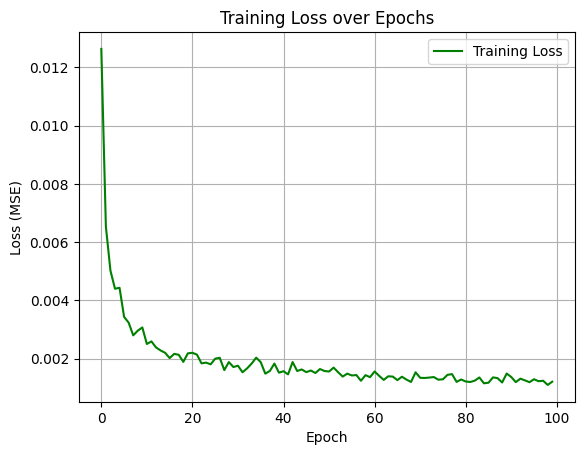

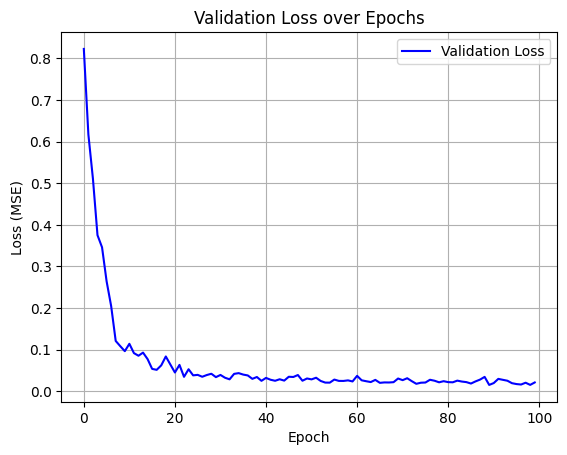

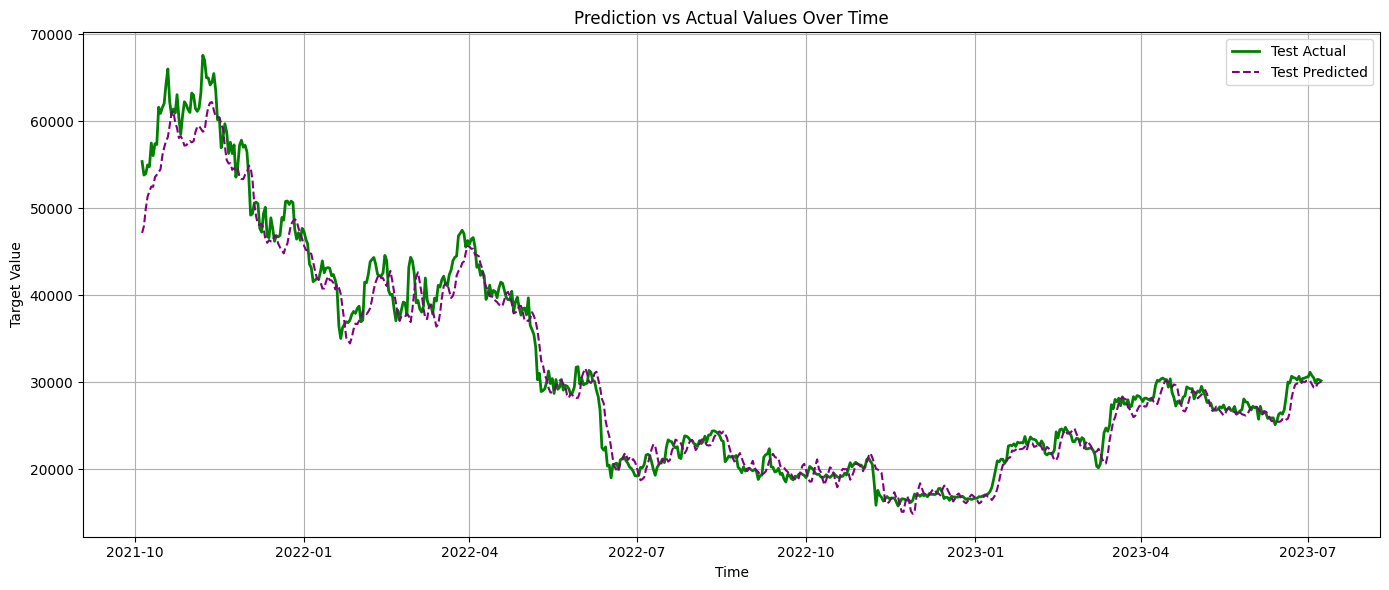

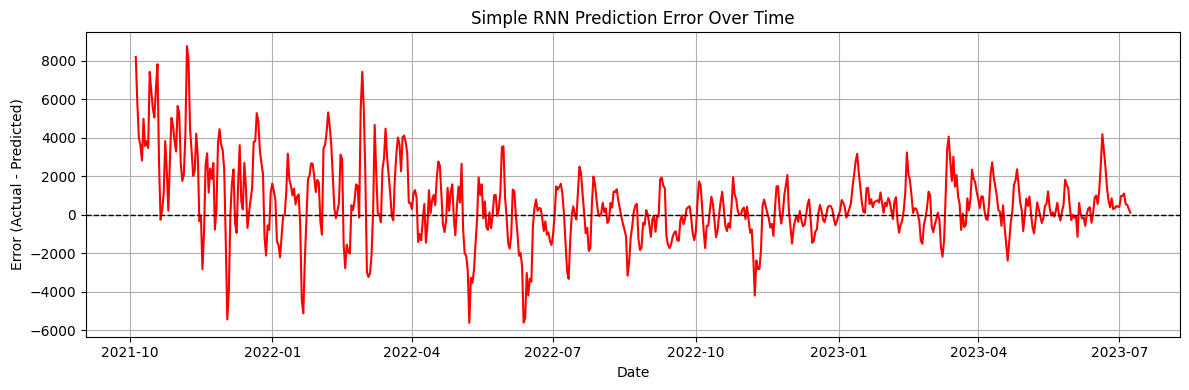

In [39]:
evaluate_and_visualize("Simple RNN", y_pred_rnn_tensorflow_by_lookback[30][0], y_pred_rnn_tensorflow_by_lookback[30][1], 30)

LSTM:

**********************LSTM**********************
Mean Squared Error (MSE): 645726551.8578
Root Mean Squared Error (RMSE): 25411.1501
Mean Absolute Error (MAE): 23223.6755
Mean Absolute Percentage Error (MAPE): 70.20%
Cumulative Error (CE): 9571962993.1391


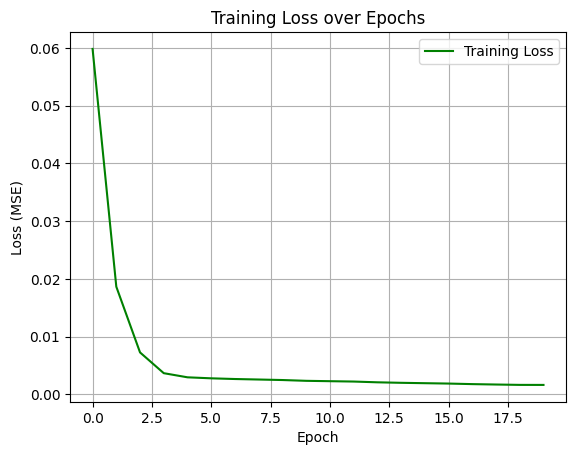

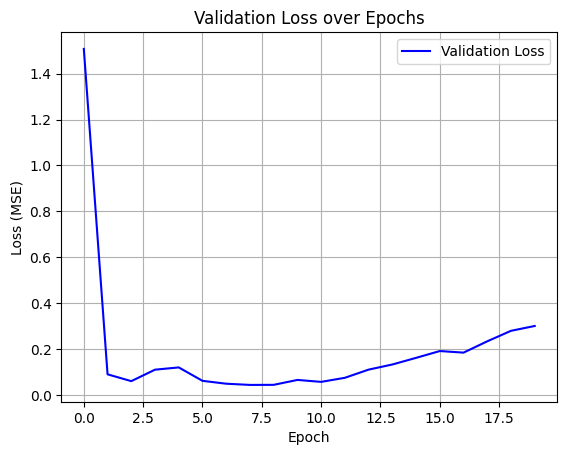

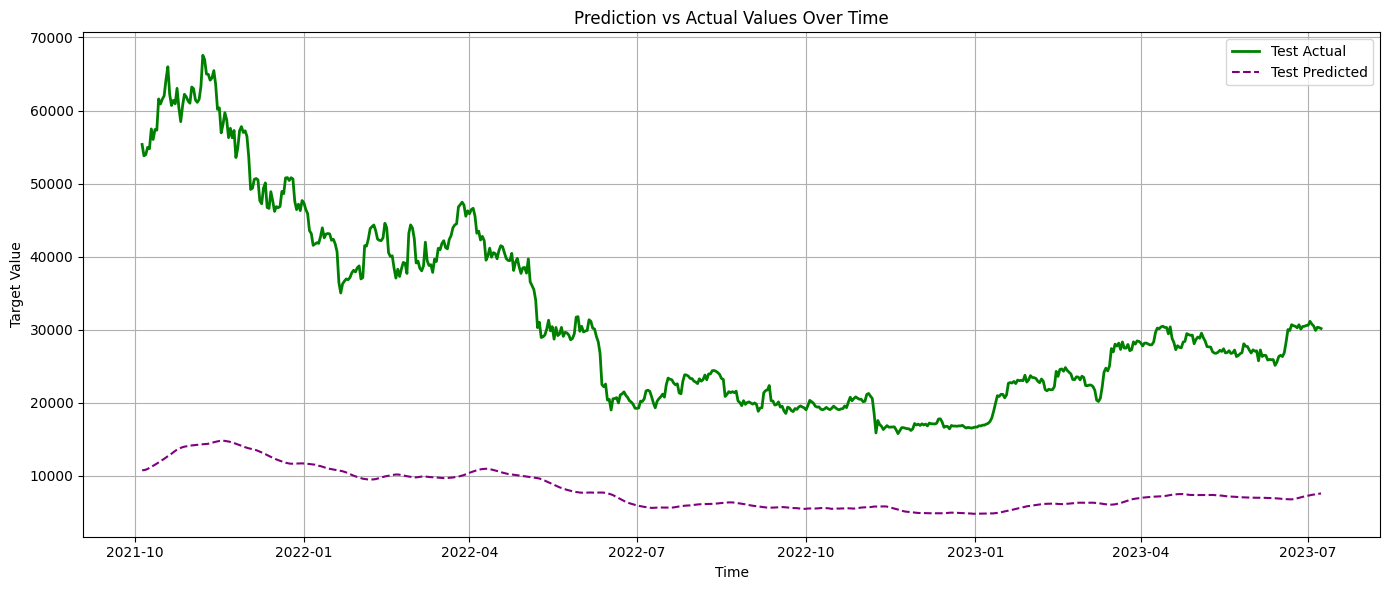

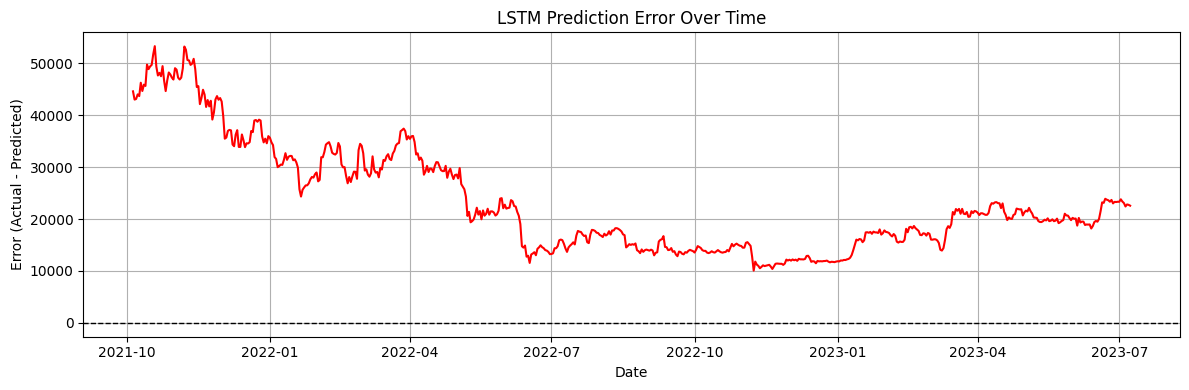

In [38]:
evaluate_and_visualize("LSTM", y_pred_lstm_tensorflow_by_lookback[30][0], y_pred_lstm_tensorflow_by_lookback[30][1], 30)

<span style="color: blue; font-size: 20px;">Lookback = 60</span>

RNN:

**********************Simple RNN**********************
Mean Squared Error (MSE): 4390870.3784
Root Mean Squared Error (RMSE): 2095.4404
Mean Absolute Error (MAE): 1524.0295
Mean Absolute Percentage Error (MAPE): 46.91%
Cumulative Error (CE): 238450213.0883


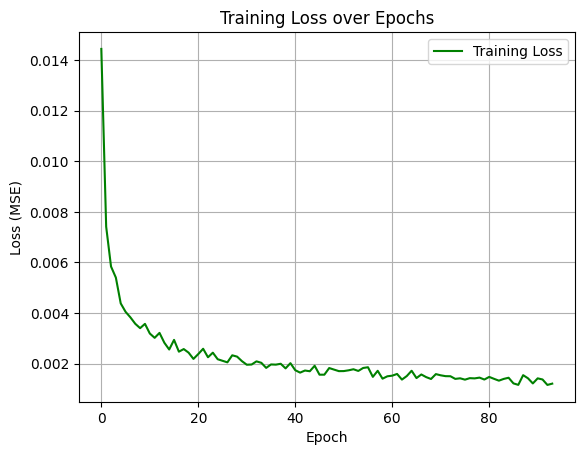

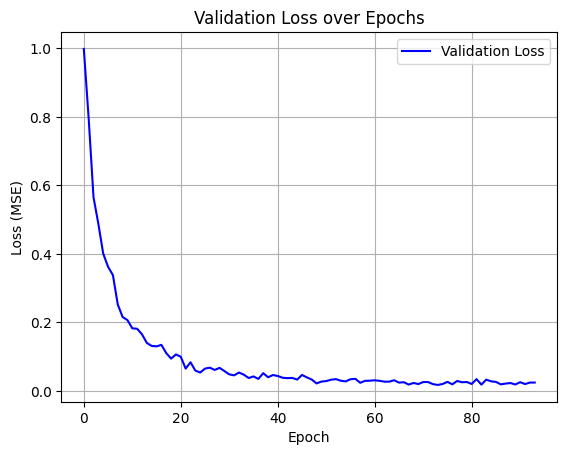

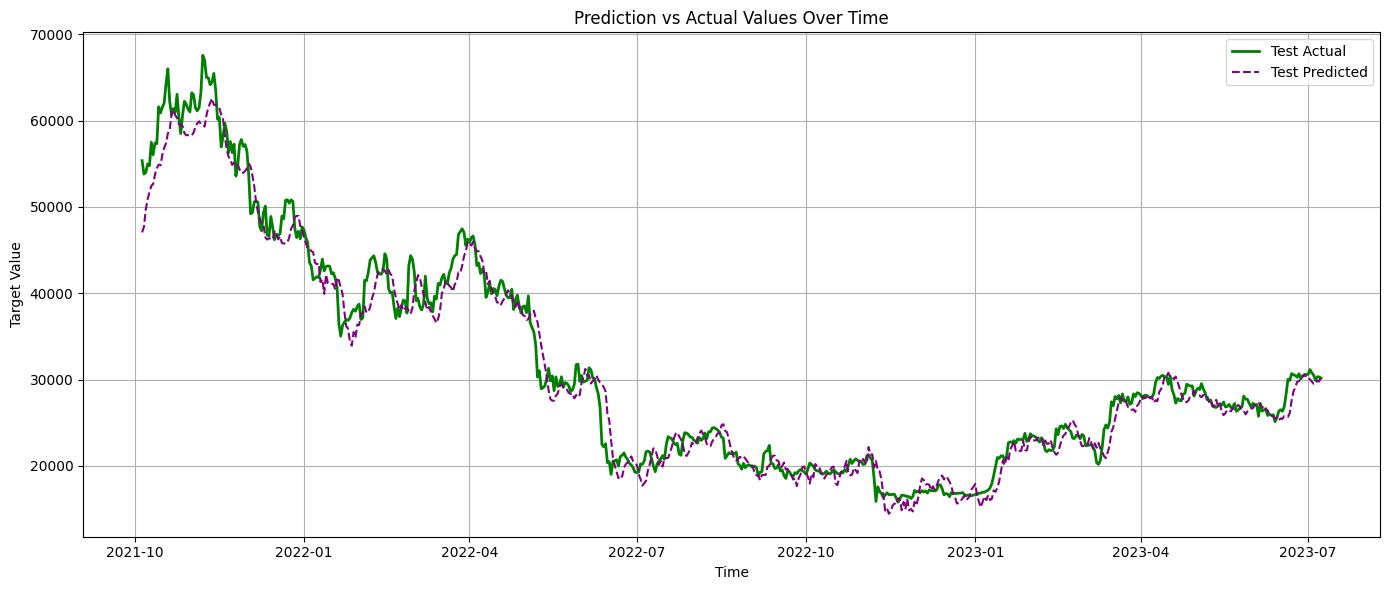

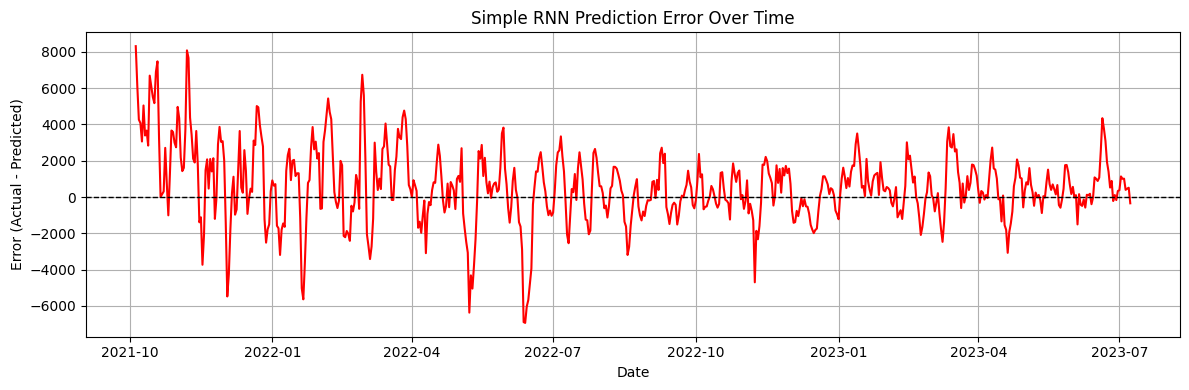

In [40]:
evaluate_and_visualize("Simple RNN", y_pred_rnn_tensorflow_by_lookback[60][0], y_pred_rnn_tensorflow_by_lookback[60][1], 60)

LSTM:

**********************LSTM**********************
Mean Squared Error (MSE): 653983072.7134
Root Mean Squared Error (RMSE): 25573.0927
Mean Absolute Error (MAE): 23399.6625
Mean Absolute Percentage Error (MAPE): 70.85%
Cumulative Error (CE): 9644498489.7934


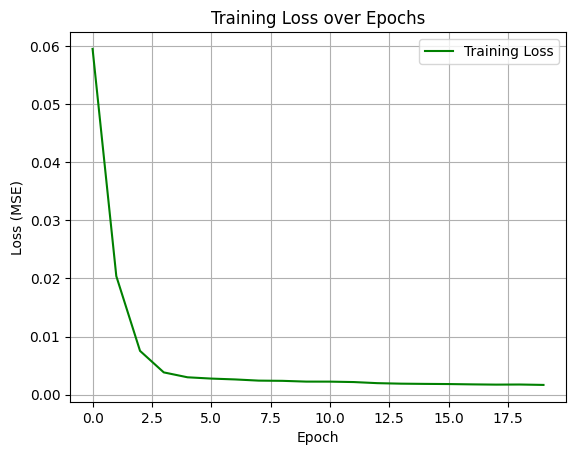

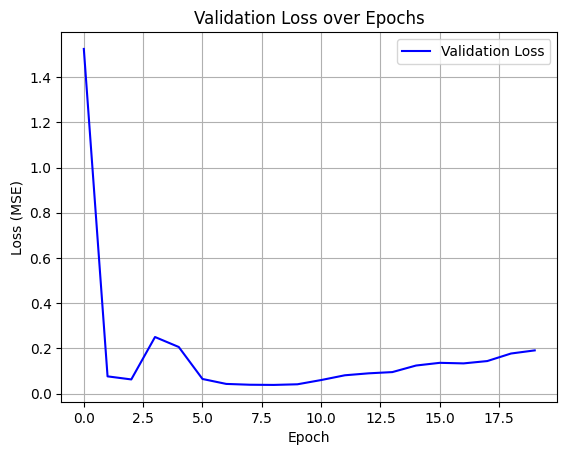

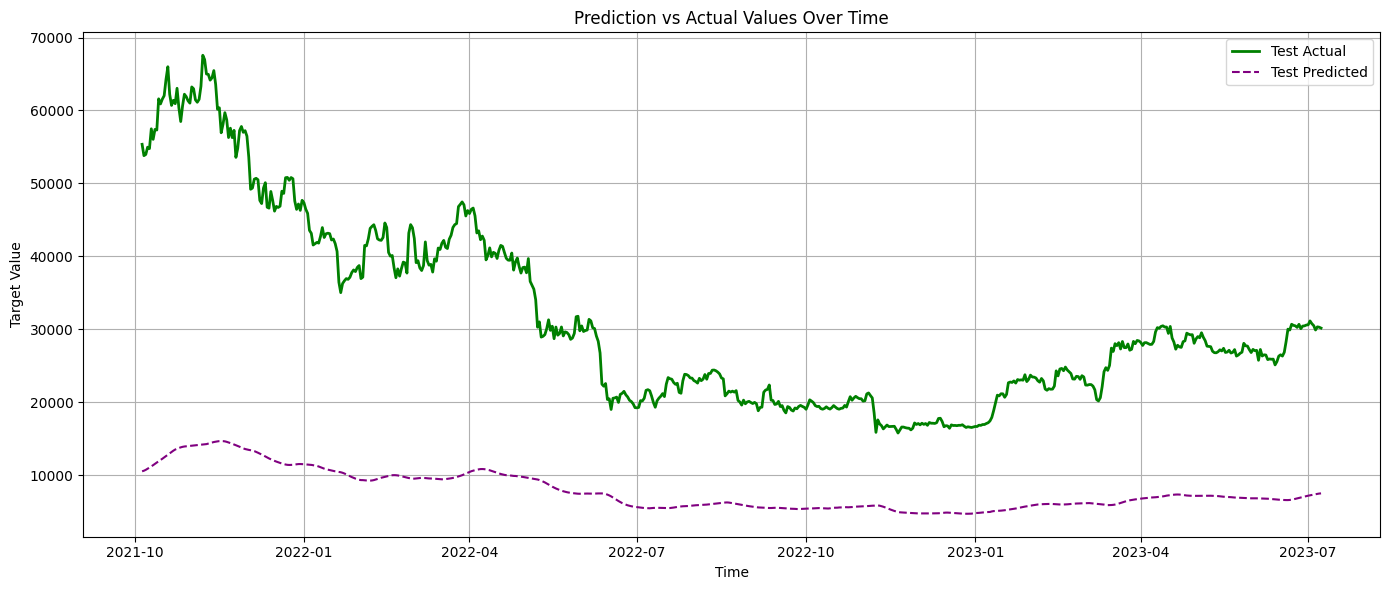

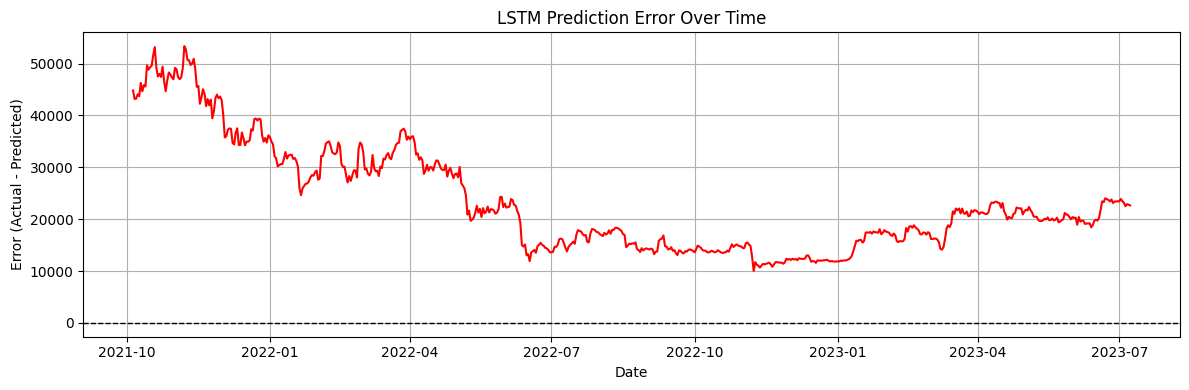

In [41]:
evaluate_and_visualize("LSTM", y_pred_lstm_tensorflow_by_lookback[60][0], y_pred_lstm_tensorflow_by_lookback[60][1], 60)

<span style="color: blue; font-size: 20px;">Lookback = 90</span>

RNN:

**********************Simple RNN**********************
Mean Squared Error (MSE): 3987635.7524
Root Mean Squared Error (RMSE): 1996.9065
Mean Absolute Error (MAE): 1411.9831
Mean Absolute Percentage Error (MAPE): 47.51%
Cumulative Error (CE): 114550752.2094


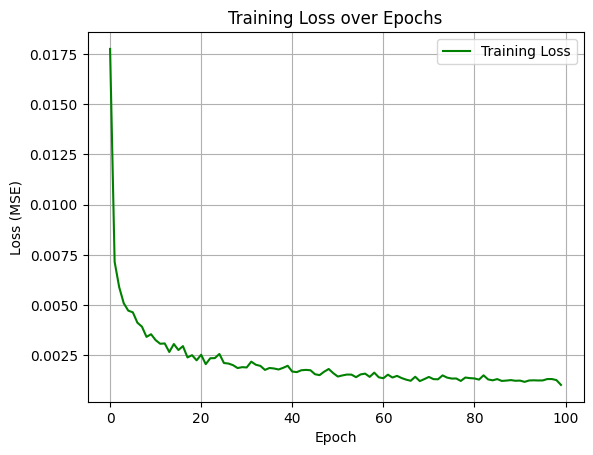

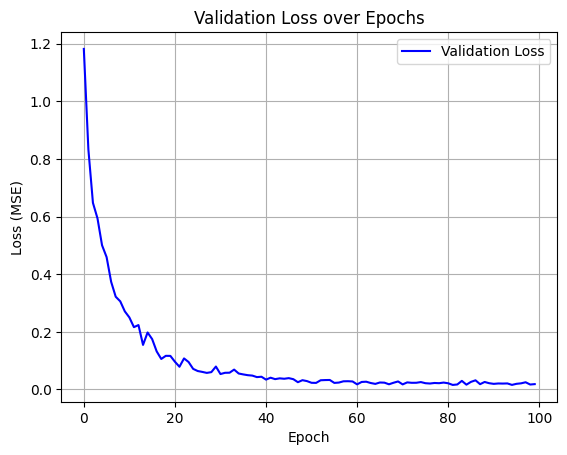

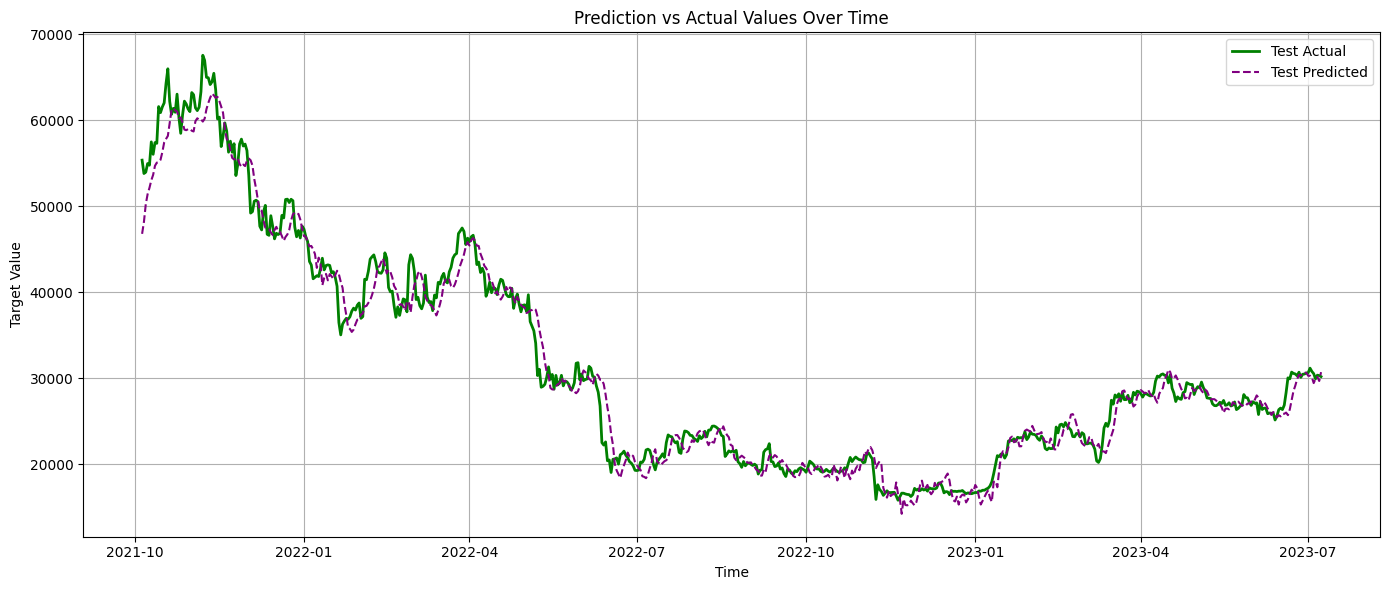

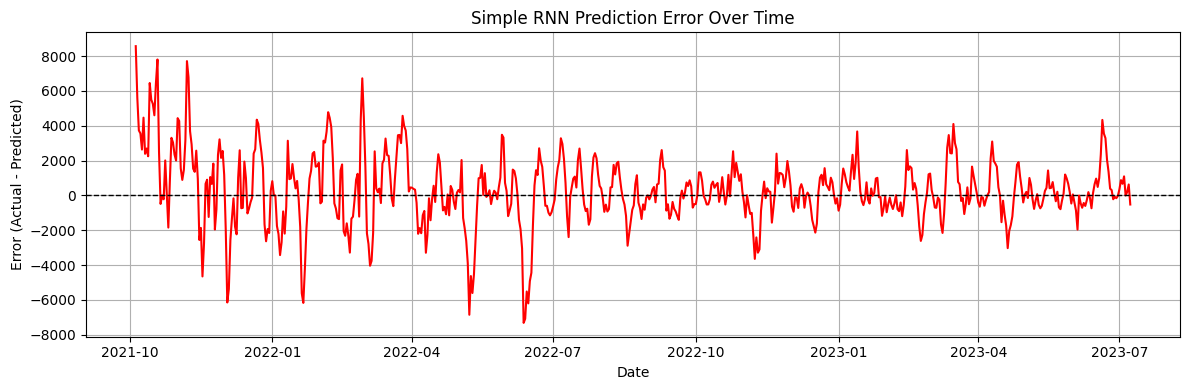

In [42]:
evaluate_and_visualize("Simple RNN", y_pred_rnn_tensorflow_by_lookback[90][0], y_pred_rnn_tensorflow_by_lookback[90][1], 90)

LSTM:

**********************LSTM**********************
Mean Squared Error (MSE): 617651156.2932
Root Mean Squared Error (RMSE): 24852.5885
Mean Absolute Error (MAE): 22738.3904
Mean Absolute Percentage Error (MAPE): 68.40%
Cumulative Error (CE): 9371945958.9887


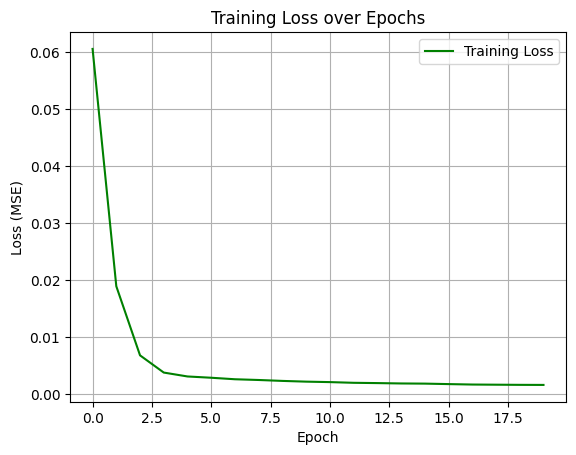

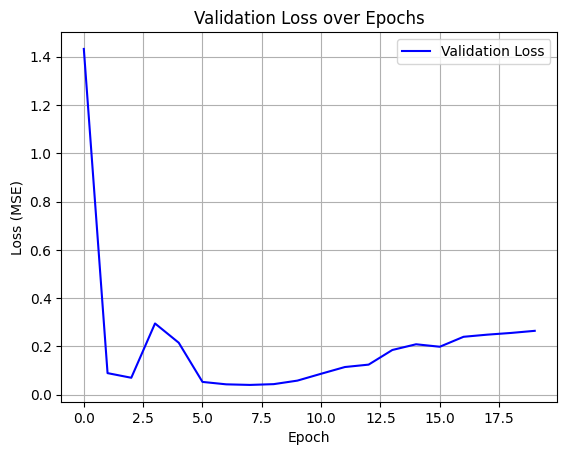

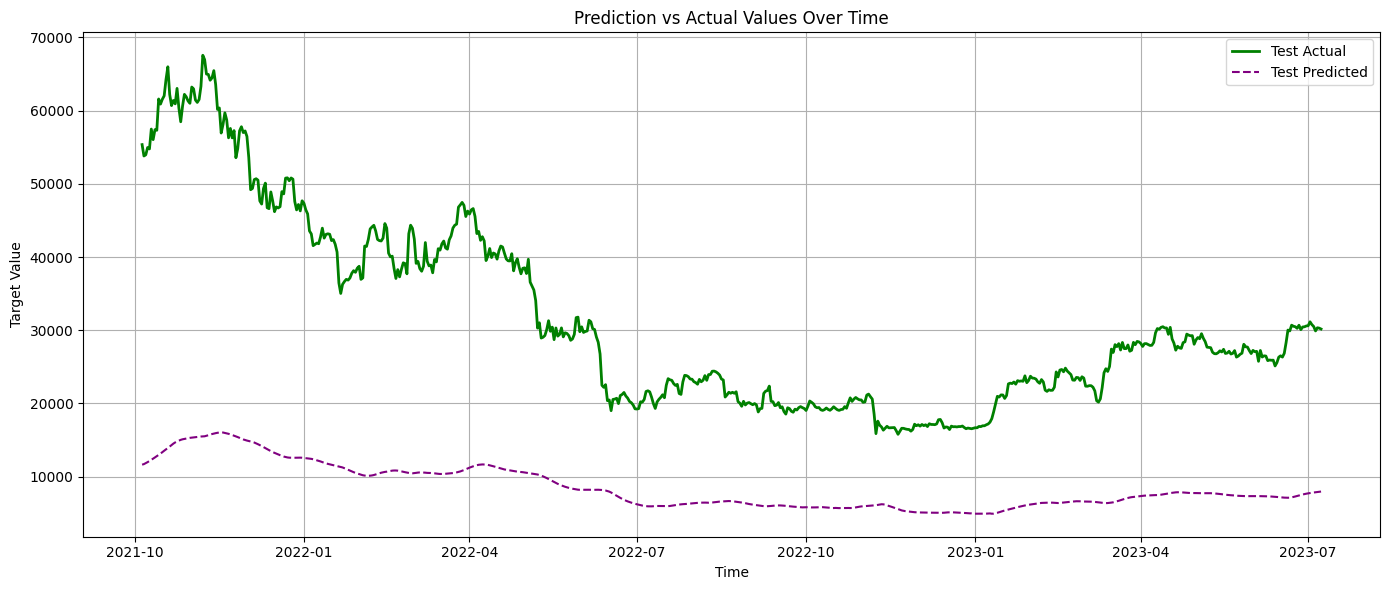

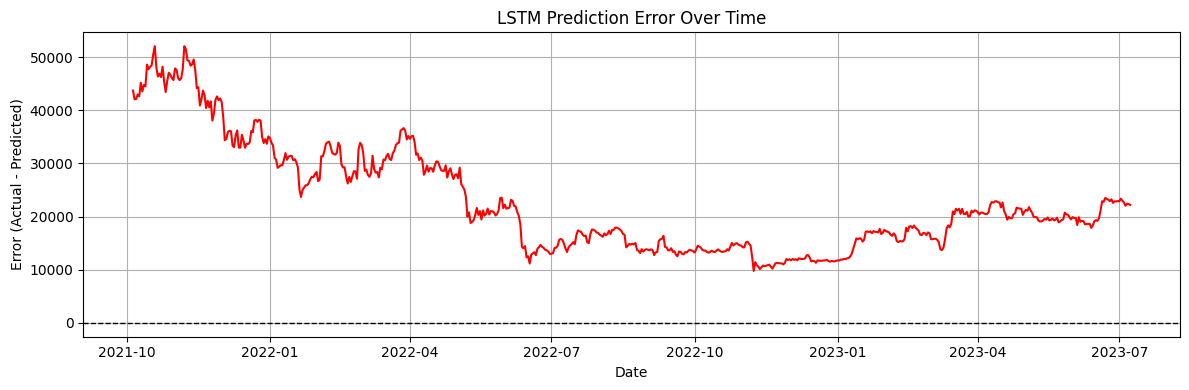

In [43]:
evaluate_and_visualize("LSTM", y_pred_lstm_tensorflow_by_lookback[90][0], y_pred_lstm_tensorflow_by_lookback[90][1], 90)

## Bonus Q3 Answer:

In a simple RNN, the hidden state at time t is calculated as:

h_t = tanh(W_hh * h_{t-1} + W_xh * x_t)

When we train the model using Backpropagation Through Time (BPTT), gradients flow backwards through each time step. The gradient of the loss with respect to the weights includes terms like:

∂L/∂W_hh = ∑_t (∂L/∂h_t) * (∂h_t/∂h_{t-1}) * (∂h_{t-1}/∂h_{t-2}) * ... * (∂h_k/∂W_hh)

Each ∂h_t/∂h_{t-1} involves W_hh and the derivative of tanh, which is less than 1.

Why the Gradient Vanishes
Each step multiplies the gradient by a value < 1:

∂h_t/∂h_{t-1} ≈ W_hh^T * diag(1 - tanh^2(...))

So:

(W_hh)^n → 0  as  n → large

Which means that gradients from early time steps vanish — the network doesn't learn long-term dependencies.

Effect of Lookback Window Size:

A larger lookback means more time steps → more gradient multiplications.
More multiplications → higher chance the gradient goes to zero.
So, vanishing gradient gets worse as lookback increases.

